In [154]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

%matplotlib inline
np.random.seed(0)
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"training on {device}")

training on cuda


## Data

In [164]:
batch_size = 128

transform = ToTensor()

data_path = "/home/ushtro/Documents/AI_ML/MyWork/computer-vision/data"
train_data = MNIST(root=data_path, train=True, download =True, transform=transform)
test_data = MNIST(root=data_path, train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

print("Data ready!")

Data ready!


## Model
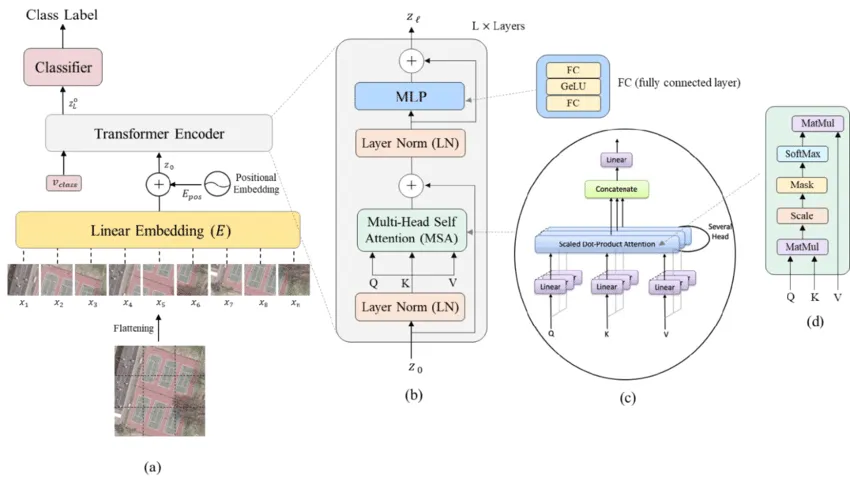

### 1. Making Patches and Linear Mapping

In [165]:
def pathify(images, n_patches):
    """ This function turns the image into patches of 'n_patches' part"""
    n, c, h, w = images.shape
    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()

    return patches

### 2. Adding classification token
This is a special token(tensor) that we add to our model that has the role of capturing information about the other tokens. This will happen with the MSA block. When information about all other tokens will be present here, we will be able to classify the image using inly this special token.

### 3. Positional Encoding
Positional encoding allows the model to understand where each patch would be placed in the original image. While it is theoritical possible to learn such positional embeddings, suggests that we can add sines and cosines waves.

For the positional encoding formula:

p_{i,j} = 
\begin{cases} 
\sin\left(\frac{i}{10000^{\frac{j}{d_{\text{emb\_dim}}}}}\right), & \text{if } j \text{ is even} \\
\cos\left(\frac{i}{10000^{\frac{j-1}{d_{\text{emb\_dim}}}}}\right), & \text{if } j \text{ is odd}
\end{cases}

In [166]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

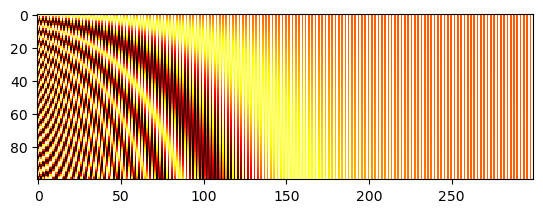

In [167]:
plt.imshow(get_positional_encoding(100, 300), cmap='hot', interpolation="nearest")
plt.show()

### Encoder block(Part 1/2)
 - Layer Normalization
 - Multi-head Self Attention
 - Residual Connection

In [168]:
class MSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads=n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])

        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N. seq_length. n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, itme_dim)

        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head+1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)

            result.append(torch.hstack(seq_result))

        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

#### Residual Connection

In [169]:
class ViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(ViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio*hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

### Classification MLP

### Vision Tranformer Model

In [170]:
class ViT(nn.Module):
    def __init__(self, chw=(1, 28, 28), n_patches = 7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # super constructor
        super(ViT, self).__init__()

        # Attributes
        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # input shape should be exactly divisible by the number of patches
        assert chw[1] % n_patches == 0 
        assert chw[2] % n_patches == 0
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # Linear mapping
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2. Learnablt classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3. Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)

        # 4. Transformer Encoder Block
        self.blocks = nn.ModuleList([ViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])

        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    
    def forward(self, images):
        n, c, h, w = images.shape
        patches = pathify(images, self.n_patches).to(device)
        tokens = self.linear_mapper(patches)

        # Adding classification tokens to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Add positional embeddings
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks
        for block in self.blocks:
            out = block(out)

        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out)

In [171]:
model = ViT((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 10
LR = 0.005
optimizer = Adam(model.parameters(), lr = LR)
criterion = CrossEntropyLoss()

## Training Loop

In [172]:
from tqdm import tqdm, trange

for epoch in trange(N_EPOCHS, desc="Training", leave=True):
    train_loss = 0.0
    # Use `position` to avoid conflicts if multiple progress bars are displayed
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} in training", leave=False, position=0):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{N_EPOCHS} loss: {train_loss:.2f}")


Training:  10%|████▌                                        | 1/10 [02:00<18:06, 120.68s/it]

Epoch 1/10 loss: 2.11


Training:  20%|█████████                                    | 2/10 [03:49<15:11, 113.99s/it]

Epoch 2/10 loss: 1.95


Training:  30%|█████████████▌                               | 3/10 [05:28<12:27, 106.78s/it]

Epoch 3/10 loss: 1.91


Training:  40%|██████████████████                           | 4/10 [07:04<10:15, 102.56s/it]

Epoch 4/10 loss: 1.81


Training:  50%|██████████████████████▌                      | 5/10 [08:46<08:32, 102.44s/it]

Epoch 5/10 loss: 1.78


Training:  60%|███████████████████████████                  | 6/10 [10:27<06:47, 101.97s/it]

Epoch 6/10 loss: 1.76


Training:  70%|███████████████████████████████▍             | 7/10 [12:04<05:01, 100.37s/it]

Epoch 7/10 loss: 1.75


Training:  80%|████████████████████████████████████▊         | 8/10 [13:38<03:16, 98.34s/it]

Epoch 8/10 loss: 1.74


Training:  90%|█████████████████████████████████████████▍    | 9/10 [15:17<01:38, 98.50s/it]

Epoch 9/10 loss: 1.73


Training: 100%|████████████████████████████████████████████| 10/10 [16:55<00:00, 101.56s/it]

Epoch 10/10 loss: 1.70


## Test Loop    

In [173]:
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Testing: 100%|██████████████████████████████████████████████| 79/79 [00:10<00:00,  7.44it/s]

Test loss: 1.66
Test accuracy: 80.18%


# End of Notebook